In [1]:
from PIL import Image
from PIL import ImageChops, ImageOps, ImageDraw
import glob
import math
import numpy as np
import tqdm
from IPython.display import display

In [2]:
files = glob.glob("photos-scene/output*.png")
ref_fn = "photos-scene/ref.png"


def _get_new_shape_maintain_ratio(target_size, current_shape):
    if current_shape[0] >= current_shape[1]:
        i1, i2 = 0, 1
    else:
        i1, i2 = 1, 0
    ratio = current_shape[i2] / current_shape[i1]
    new_shape = [0, 0]
    new_shape[i1] = int(target_size)
    new_shape[i2] = int(math.ceil(target_size * ratio))
    return new_shape


def display_thumbnail(img):
    return display(img.resize(_get_new_shape_maintain_ratio(1024, img.size)))

(3840, 2160) (3840, 2160) (3840, 2160)
=======reference=======


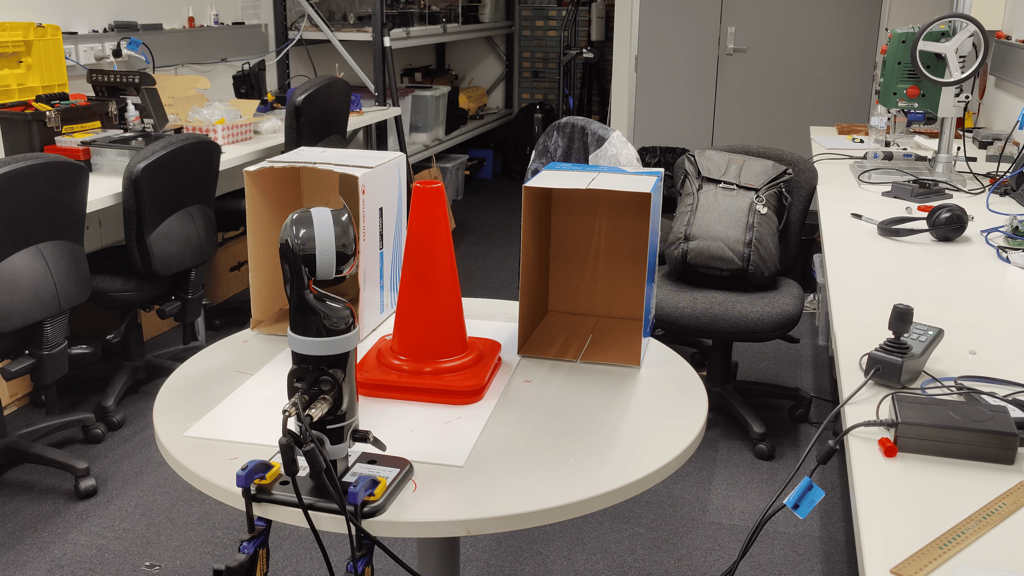

=======Pic 1=======


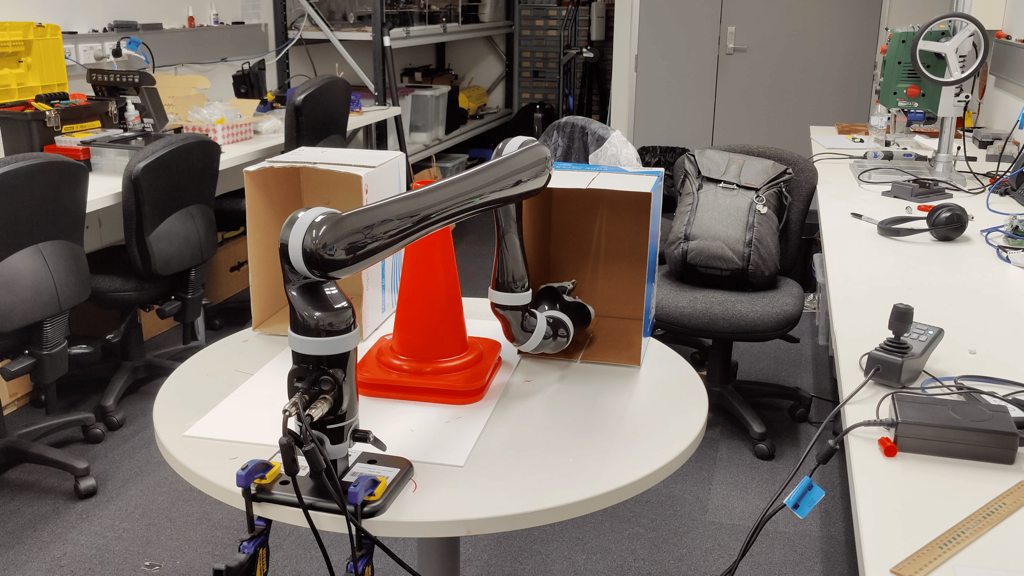

In [3]:
im1 = Image.open(files[2]).convert("RGB")
im2 = Image.open(files[3]).convert("RGB")
ref = Image.open(ref_fn).convert("RGB")
print(im1.size, im2.size, ref.size)

print("=======reference=======")
display_thumbnail(ref)
print("=======Pic 1=======")
display_thumbnail(im1)

In [4]:
diff = ImageChops.difference(im1, ref)

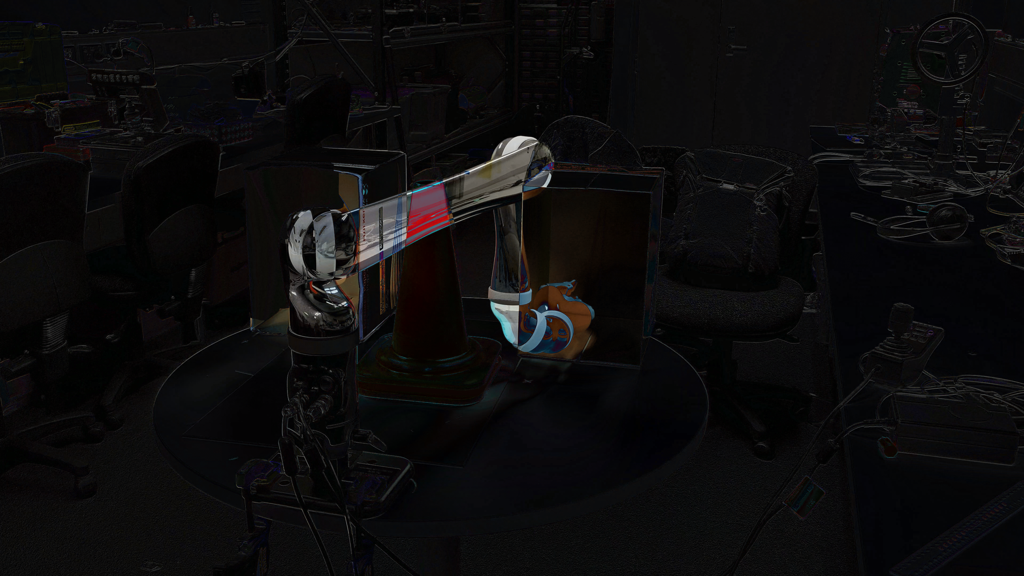

In [5]:
display_thumbnail(diff)

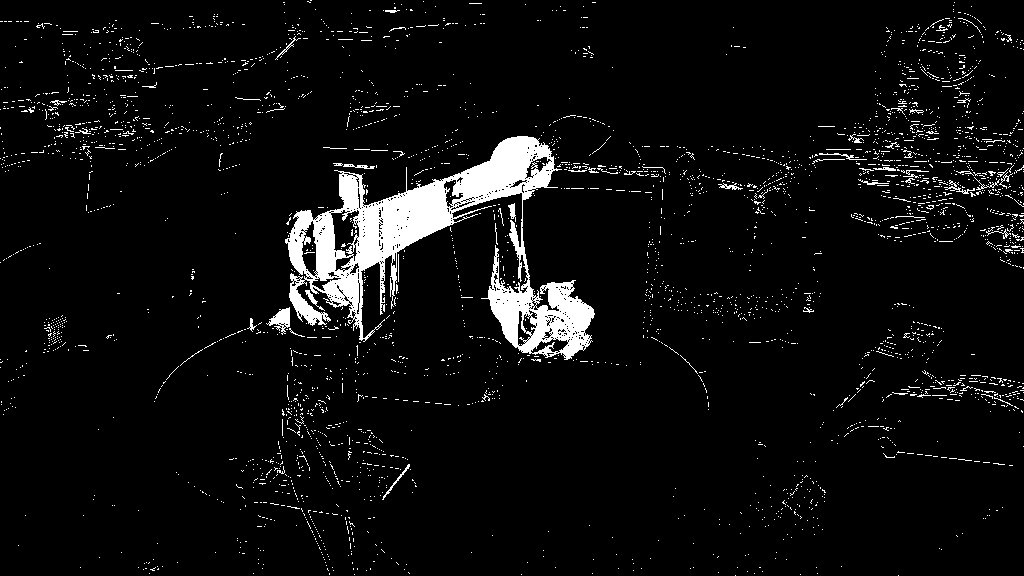

In [6]:
def get_diff_mask(im, ref, norm_diff=60, mask_vals=255, asarray=True):
    diff = ImageChops.difference(im, ref)
    norm = np.linalg.norm(np.array(diff), axis=2)
    mask = norm > norm_diff
    if not asarray:
        mask = Image.fromarray((mask * mask_vals).astype(np.uint8))
    return Image.fromarray(mask)


def get_alpha_image(im, ref, norm_diff=20):
    mask = get_diff_mask(im, ref, norm_diff=norm_diff)
    im_alpha = im.copy()
    im_alpha.putalpha(mask)
    return im_alpha


def remove_unwanted_color(image, color=[212, 20, 0], threshold=30):
    close_to_unwanted_color = (
        np.linalg.norm(np.array(image) - np.array(color), axis=2) < threshold
    )

    image = image.copy()
    image_data = image.load()
    height, width = image.size
    alpha = np.ones(image.size).astype(np.uint8) * 255
    for loop1 in range(height):
        for loop2 in range(width):
            if close_to_unwanted_color[loop2, loop1]:
                r, g, b = image_data[loop1, loop2]
                image_data[loop1, loop2] = 0, 0, 0
                alpha[loop1, loop2] = 0
    return image, alpha


mask = get_diff_mask(im1, ref)
display_thumbnail(mask)

100%|███████████████████████████████████████████████████████████████████████████████████| 31/31 [00:50<00:00,  1.62s/it]


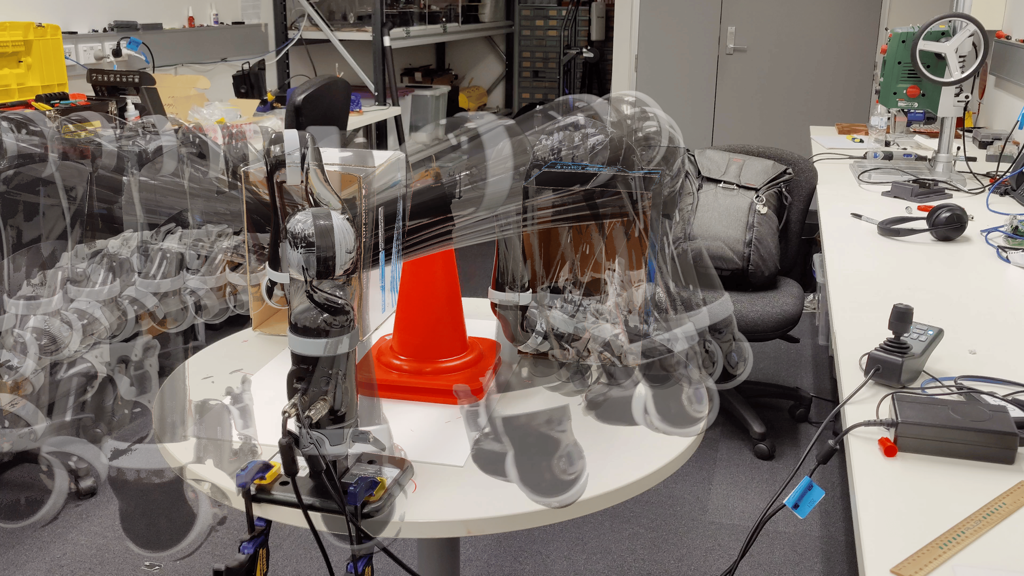

In [7]:
_files = files[:]
main_img = ref.copy()

main_img = Image.open(files[0]).convert("RGB")

for fn in tqdm.tqdm(_files):
    im = Image.open(fn).convert("RGB")
    __img, alpha = remove_unwanted_color(im, threshold=150)

    diff_mask = get_diff_mask(im, ref, 70, asarray=True)
    final_mask = np.logical_and((alpha == 255).T, diff_mask)

    main_img.paste(im, (0, 0), Image.fromarray((final_mask * 140).astype(np.uint8)))

display_thumbnail(main_img)